# 03.1 - Feature Selection (COMMUN)

**Projet:** Credit Scoring - Home Credit Default Risk

**Objectif:** Selectionner les features les plus pertinentes pour la modelisation.

**IMPORTANT:** Ce notebook doit etre execute par UNE SEULE personne, puis les resultats sont partages avec tous.

---

## Methodes de selection

1. **Variance Threshold** - Elimine features a variance quasi-nulle
2. **Correlation Filter** - Elimine features tres correlees entre elles (>0.95)
3. **Mutual Information** - Score par information mutuelle avec TARGET
4. **LightGBM Importance** - Feature importance d'un modele de reference

---

## Livrables

- `artifacts/selected_features/feature_selector.pkl` - Selecteur entraine
- `artifacts/selected_features/selected_features.txt` - Liste des features
- `data/processed/train_selected.csv` - Train avec features selectionnees
- `data/processed/test_selected.csv` - Test avec features selectionnees

## 1. Setup

In [9]:
import sys
sys.path.insert(0, '..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings

warnings.filterwarnings('ignore')

# Import du selecteur
from src.selection import FeatureSelector, select_features

print("Imports OK")

Imports OK


In [10]:
# Configuration
DATA_PATH = Path('../data/processed')
ARTIFACTS_PATH = Path('../artifacts/selected_features')

# Creer dossier artifacts si necessaire
ARTIFACTS_PATH.mkdir(parents=True, exist_ok=True)

# Parametres de selection
N_FEATURES = 100  # Nombre de features a selectionner
VARIANCE_THRESHOLD = 0.01
CORRELATION_THRESHOLD = 0.95

print(f"Parametres:")
print(f"  - N_FEATURES: {N_FEATURES}")
print(f"  - VARIANCE_THRESHOLD: {VARIANCE_THRESHOLD}")
print(f"  - CORRELATION_THRESHOLD: {CORRELATION_THRESHOLD}")

Parametres:
  - N_FEATURES: 100
  - VARIANCE_THRESHOLD: 0.01
  - CORRELATION_THRESHOLD: 0.95


## 2. Chargement des donnees preprocessees

In [11]:
# Charger les donnees preprocessees
train = pd.read_csv(DATA_PATH / 'train_processed.csv')
test = pd.read_csv(DATA_PATH / 'test_processed.csv')

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")
print(f"\nTarget distribution:")
print(train['TARGET'].value_counts(normalize=True))

Train shape: (307511, 193)
Test shape: (48744, 192)

Target distribution:
TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64


In [12]:
# Verifier les types de colonnes
print("Types de colonnes:")
print(train.dtypes.value_counts())

# Colonnes numeriques
numeric_cols = train.select_dtypes(include=[np.number]).columns.tolist()
print(f"\nColonnes numeriques: {len(numeric_cols)}")

# Colonnes non-numeriques
non_numeric_cols = train.select_dtypes(exclude=[np.number]).columns.tolist()
print(f"Colonnes non-numeriques: {len(non_numeric_cols)}")
if non_numeric_cols:
    print(f"  {non_numeric_cols}")

Types de colonnes:
float64    128
int64       49
object      16
Name: count, dtype: int64

Colonnes numeriques: 177
Colonnes non-numeriques: 16
  ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']


## 3. Analyse exploratoire rapide

In [13]:
# Valeurs manquantes
missing = train.isnull().sum()
missing_pct = missing / len(train) * 100

print(f"Colonnes avec valeurs manquantes: {(missing > 0).sum()}")
print(f"\nTop 10 colonnes avec plus de manquantes:")
print(missing_pct[missing_pct > 0].sort_values(ascending=False).head(10))

Colonnes avec valeurs manquantes: 0

Top 10 colonnes avec plus de manquantes:
Series([], dtype: float64)


In [14]:
# Distribution de la variance
X = train.drop(columns=['TARGET'], errors='ignore')
X_numeric = X.select_dtypes(include=[np.number])

variances = X_numeric.var()

print(f"Variance - Statistiques:")
print(f"  Min: {variances.min():.6f}")
print(f"  Max: {variances.max():.2f}")
print(f"  Median: {variances.median():.4f}")
print(f"\nFeatures avec variance < {VARIANCE_THRESHOLD}: {(variances < VARIANCE_THRESHOLD).sum()}")

Variance - Statistiques:
  Min: 0.000003
  Max: 14884982741906.45
  Median: 0.0544

Features avec variance < 0.01: 71


## 4. Selection de features

In [15]:
# Separer features et target
X_train = train.drop(columns=['TARGET'])
y_train = train['TARGET']

# Garder uniquement colonnes numeriques pour la selection
X_train_numeric = X_train.select_dtypes(include=[np.number])

print(f"Features pour selection: {X_train_numeric.shape[1]}")

Features pour selection: 176


In [16]:
# Creer et entrainer le selecteur
selector = FeatureSelector(
    methods=['variance', 'correlation', 'mutual_info', 'lightgbm'],
    n_features=N_FEATURES,
    variance_threshold=VARIANCE_THRESHOLD,
    correlation_threshold=CORRELATION_THRESHOLD,
    random_state=42
)

# Fit sur train
X_train_selected = selector.fit_transform(X_train_numeric, y_train)


FIT: Apprentissage des parametres de selection
Shape initial: (307511, 176)
Methodes: ['variance', 'correlation', 'mutual_info', 'lightgbm']
Features numeriques: 176

1. Variance Threshold Analysis...
   Seuil: 0.01
   Features a faible variance: 71
   Exemples elimines: ['FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_19', 'FLOORSMIN_AVG', 'BUREAU_CREDIT_TYPE_Mobile operator loan', 'LIVINGAPARTMENTS_AVG']
Apres variance filter: 105 features

2. Correlation Filter Analysis...
   Seuil: 0.95
   Paires tres correlees: 10
   Features a eliminer: 9
   Top correlations:
      DAYS_EMPLOYED_ANOM <-> FLAG_EMP_PHONE: 0.9999
      OBS_60_CNT_SOCIAL_CIRCLE <-> OBS_30_CNT_SOCIAL_CIRCLE: 0.9985
      FLOORSMAX_MEDI <-> FLOORSMAX_AVG: 0.9973
Apres correlation filter: 96 features

3. Mutual Information Analysis...
   Top 10 features par MI:
      HAS_POS: 0.0375
      HAS_PREV: 0.0370
      HAS_INST: 0.0361
      FLAG_DOCUMENT_3: 0.0284
      HAS_EXT_SOURCE_3: 0.0282
      FLAG_EMP_PHONE: 0.0276
      HAS_BUREAU

In [17]:
# Resume de la selection
print("\n" + "="*60)
print("RESUME DE LA SELECTION")
print("="*60)

print(f"\nFeatures initiales: {X_train_numeric.shape[1]}")
print(f"Features selectionnees: {len(selector.selected_features_)}")

# Features eliminees par methode
dropped = selector.get_dropped_features()
print(f"\nFeatures eliminees par methode:")
for method, features in dropped.items():
    print(f"  - {method}: {len(features)} features")


RESUME DE LA SELECTION

Features initiales: 176
Features selectionnees: 96

Features eliminees par methode:
  - variance: 71 features
  - correlation: 9 features


In [18]:
# Top features selectionnees
selected_features = selector.get_selected_features()

print(f"\nTop 20 features selectionnees:")
for i, feat in enumerate(selected_features[:20], 1):
    score = selector.feature_scores_.get(feat, 0)
    print(f"  {i:2d}. {feat}: {score:.4f}")


Top 20 features selectionnees:
   1. EXT_SOURCE_1: 0.4487
   2. BUREAU_AMT_CREDIT_SUM_SUM: 0.4268
   3. EXT_SOURCE_2: 0.3826
   4. EXT_SOURCE_3: 0.3719
   5. HAS_POS: 0.3333
   6. HAS_PREV: 0.3291
   7. HAS_INST: 0.3210
   8. FLAG_DOCUMENT_3: 0.2918
   9. AMT_CREDIT: 0.2694
  10. AMT_ANNUITY: 0.2645
  11. DAYS_BIRTH: 0.2625
  12. HAS_EXT_SOURCE_3: 0.2544
  13. FLAG_EMP_PHONE: 0.2458
  14. HAS_BUREAU: 0.2333
  15. POS_CNT_INSTALMENT_FUTURE_MEAN: 0.2313
  16. INST_AMT_PAYMENT_SUM: 0.2106
  17. CC_AMT_BALANCE_MEAN: 0.1983
  18. INST_DAYS_DELAY_MEAN: 0.1964
  19. HAS_EXT_SOURCE_1: 0.1791
  20. DAYS_EMPLOYED: 0.1755


## 5. Visualisation des scores

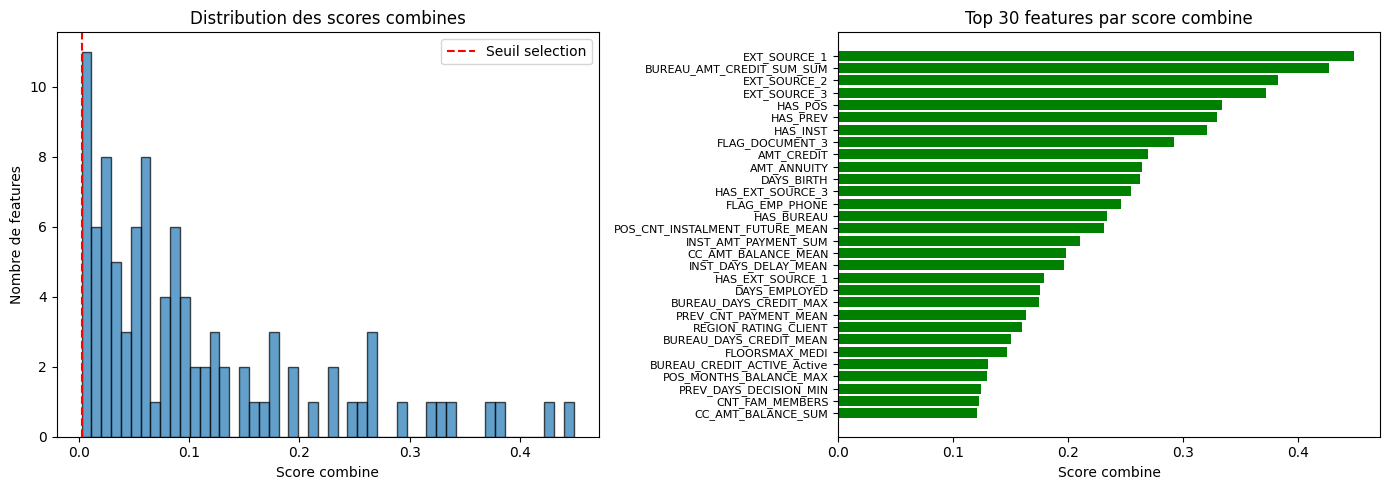

In [19]:
# Distribution des scores combines
summary_df = selector.summary()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogramme des scores
axes[0].hist(summary_df['combined_score'], bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(summary_df.loc[summary_df['selected'], 'combined_score'].min(), 
                color='red', linestyle='--', label='Seuil selection')
axes[0].set_xlabel('Score combine')
axes[0].set_ylabel('Nombre de features')
axes[0].set_title('Distribution des scores combines')
axes[0].legend()

# Top 30 features
top30 = summary_df.head(30)
colors = ['green' if s else 'gray' for s in top30['selected']]
axes[1].barh(range(len(top30)), top30['combined_score'], color=colors)
axes[1].set_yticks(range(len(top30)))
axes[1].set_yticklabels(top30.index, fontsize=8)
axes[1].invert_yaxis()
axes[1].set_xlabel('Score combine')
axes[1].set_title('Top 30 features par score combine')

plt.tight_layout()
plt.savefig(ARTIFACTS_PATH / 'feature_scores.png', dpi=150, bbox_inches='tight')
plt.show()

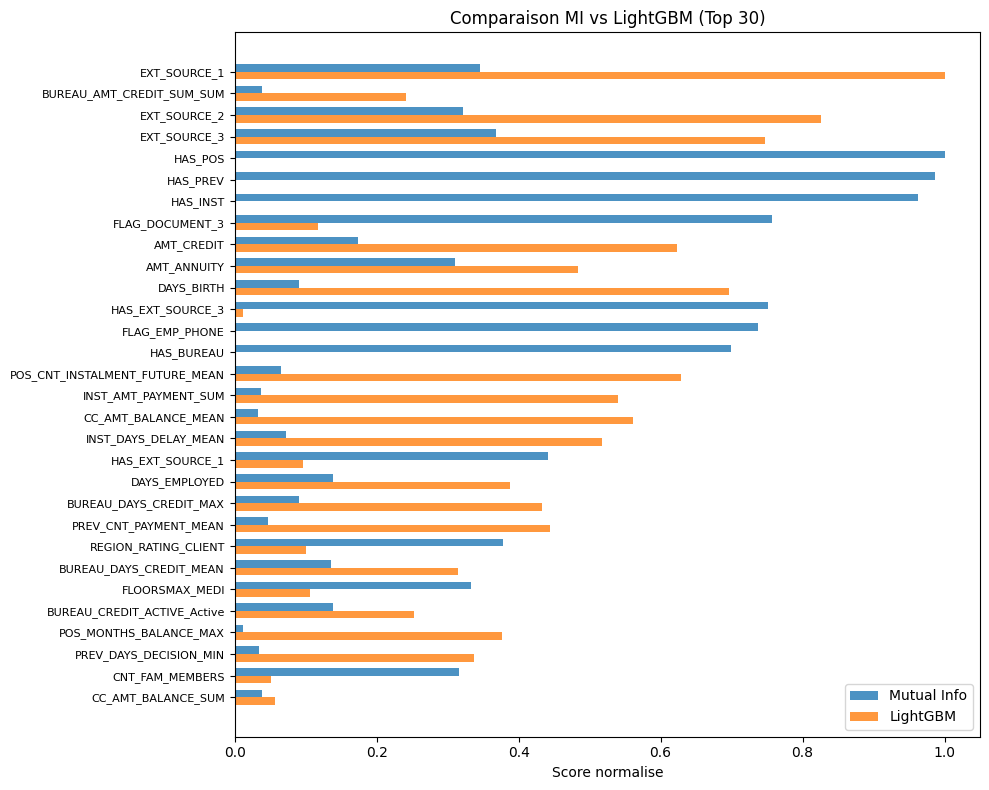

In [20]:
# Comparaison MI vs LightGBM
if selector.mutual_info_scores_ and selector.lightgbm_importance_:
    fig, ax = plt.subplots(figsize=(10, 8))
    
    mi_scores = [selector.mutual_info_scores_.get(f, 0) for f in selected_features[:30]]
    lgb_scores = [selector.lightgbm_importance_.get(f, 0) for f in selected_features[:30]]
    
    # Normaliser pour comparaison
    mi_norm = np.array(mi_scores) / (max(mi_scores) + 1e-10)
    lgb_norm = np.array(lgb_scores) / (max(lgb_scores) + 1e-10)
    
    x = np.arange(len(selected_features[:30]))
    width = 0.35
    
    ax.barh(x - width/2, mi_norm, width, label='Mutual Info', alpha=0.8)
    ax.barh(x + width/2, lgb_norm, width, label='LightGBM', alpha=0.8)
    
    ax.set_yticks(x)
    ax.set_yticklabels(selected_features[:30], fontsize=8)
    ax.invert_yaxis()
    ax.set_xlabel('Score normalise')
    ax.set_title('Comparaison MI vs LightGBM (Top 30)')
    ax.legend()
    
    plt.tight_layout()
    plt.savefig(ARTIFACTS_PATH / 'mi_vs_lgb.png', dpi=150, bbox_inches='tight')
    plt.show()

## 6. Application au test set

In [21]:
# Transformer test set
X_test = test.select_dtypes(include=[np.number])
X_test_selected = selector.transform(X_test)

print(f"Test set apres selection: {X_test_selected.shape}")


TRANSFORM: Application de la selection
Shape avant: (48744, 176)
Shape apres: (48744, 96)
Reduction: 80 features eliminees
Test set apres selection: (48744, 96)


## 7. Sauvegarde des resultats

In [22]:
# Sauvegarder le selecteur
selector.save(ARTIFACTS_PATH / 'feature_selector.pkl')

# Sauvegarder la liste des features
with open(ARTIFACTS_PATH / 'selected_features.txt', 'w') as f:
    for feat in selected_features:
        f.write(f"{feat}\n")

print(f"Selecteur sauvegarde: {ARTIFACTS_PATH / 'feature_selector.pkl'}")
print(f"Liste features sauvegardee: {ARTIFACTS_PATH / 'selected_features.txt'}")

Selecteur sauvegarde: ..\artifacts\selected_features\feature_selector.pkl
Selecteur sauvegarde: ..\artifacts\selected_features\feature_selector.pkl
Liste features sauvegardee: ..\artifacts\selected_features\selected_features.txt


In [23]:
# Creer datasets reduits pour l'equipe
train_selected = X_train_selected.copy()
train_selected['TARGET'] = y_train.values

test_selected = X_test_selected.copy()

# Sauvegarder
train_selected.to_csv(DATA_PATH / 'train_selected.csv', index=False)
test_selected.to_csv(DATA_PATH / 'test_selected.csv', index=False)

print(f"\nDatasets sauvegardes:")
print(f"  - train_selected.csv: {train_selected.shape}")
print(f"  - test_selected.csv: {test_selected.shape}")


Datasets sauvegardes:
  - train_selected.csv: (307511, 97)
  - test_selected.csv: (48744, 96)


In [24]:
# Sauvegarder le resume complet
summary_df.to_csv(ARTIFACTS_PATH / 'feature_scores_summary.csv')
print(f"Resume sauvegarde: {ARTIFACTS_PATH / 'feature_scores_summary.csv'}")

Resume sauvegarde: ..\artifacts\selected_features\feature_scores_summary.csv


## 8. Validation finale

In [25]:
# Verification des fichiers generes
print("\n" + "="*60)
print("VALIDATION FINALE")
print("="*60)

files_to_check = [
    ARTIFACTS_PATH / 'feature_selector.pkl',
    ARTIFACTS_PATH / 'selected_features.txt',
    ARTIFACTS_PATH / 'feature_scores_summary.csv',
    DATA_PATH / 'train_selected.csv',
    DATA_PATH / 'test_selected.csv'
]

print("\nFichiers generes:")
for f in files_to_check:
    if f.exists():
        size = f.stat().st_size / 1024  # KB
        print(f"  [OK] {f.name} ({size:.1f} KB)")
    else:
        print(f"  [MANQUANT] {f.name}")


VALIDATION FINALE

Fichiers generes:
  [OK] feature_selector.pkl (11.5 KB)
  [OK] selected_features.txt (2.1 KB)
  [OK] feature_scores_summary.csv (6.7 KB)
  [OK] train_selected.csv (159861.4 KB)
  [OK] test_selected.csv (25579.0 KB)


In [26]:
# Test de chargement
print("\nTest de chargement du selecteur:")
selector_loaded = FeatureSelector.load(ARTIFACTS_PATH / 'feature_selector.pkl')

# Verifier coherence
assert selector_loaded.selected_features_ == selector.selected_features_, "Incoherence features!"
print("  [OK] Selecteur charge correctement")

# Test transform
X_test_reload = selector_loaded.transform(X_test)
assert X_test_reload.shape == X_test_selected.shape, "Incoherence shape!"
print("  [OK] Transform fonctionne correctement")


Test de chargement du selecteur:
Selecteur charge: ..\artifacts\selected_features\feature_selector.pkl
Features selectionnees: 96
  [OK] Selecteur charge correctement

TRANSFORM: Application de la selection
Shape avant: (48744, 176)
Shape apres: (48744, 96)
Reduction: 80 features eliminees
  [OK] Transform fonctionne correctement


## 9. Instructions pour l'equipe

### Fichiers a partager (via Git)

1. `artifacts/selected_features/feature_selector.pkl`
2. `artifacts/selected_features/selected_features.txt`
3. `data/processed/train_selected.csv`
4. `data/processed/test_selected.csv`

### Utilisation dans vos notebooks

```python
# Option 1: Charger directement les datasets selectionnes
train = pd.read_csv('data/processed/train_selected.csv')
test = pd.read_csv('data/processed/test_selected.csv')

# Option 2: Utiliser le selecteur
from src.selection import FeatureSelector

selector = FeatureSelector.load('artifacts/selected_features/feature_selector.pkl')
X_selected = selector.transform(X)
```

### Note importante

Les features selectionnees sont **communes a tous**. Ne pas modifier cette selection pour garantir la comparabilite des resultats MLflow.

In [27]:
print("\n" + "="*60)
print("FEATURE SELECTION TERMINEE")
print("="*60)
print(f"\nFeatures selectionnees: {len(selector.selected_features_)}")
print(f"\nProchaine etape: Partager le depot et commencer la modelisation!")


FEATURE SELECTION TERMINEE

Features selectionnees: 96

Prochaine etape: Partager le depot et commencer la modelisation!
